<p style="text-align: center;"><span style="color:#262626"><span style="font-size:42px"><span style="font-family:lato,sans-serif"><span style="font-weight:bold">
The Roots of Hartree-Fock
</span></span></span></span></p>

<p style="text-align: center;"><span style="color:#262626"><span style="font-size:32px"><span style="font-family:lato,sans-serif"><span style="font-weight:bold">
and Application for a Two Atom System
</span></span></span></span></p>

<p style="text-align: left;"><span style="color:#262626"><span style="font-size:18px"><span style="font-family:lato,sans-serif">
By: Zach Stewart 
</span></span></span></p>

</span></span></span></p>
<p style="text-align: justify;"><span style="color:#262626"><span style="font-size:16px"><span style="font-family:lato,sans-serif">
Here I will be exlpaining and creating a minimal HF code, because I really underestimated how involved a general one would be.
</span></span></span></p>


### References
1. A. Szabo and N. S. Ostlund, *Modern Quantum Chemistry*, Introduction to Advanced Electronic Structure Theory. Courier Corporation, 1996.

### Just getting some convienient imports.

In [32]:
from numpy import *
from scipy.linalg import eigh, eig, inv
from scipy.special import erf, factorial, assoc_laguerre
from scipy.constants import physical_constants
import matplotlib.pyplot as plt
from matplotlib import gridspec
# conversions: atomic units to eV and bohr (a0) to angstrom
au2eV = physical_constants['Hartree energy in eV'][0]
bohr2ang = physical_constants['Bohr radius'][0]*1e10

%matplotlib inline

In [126]:
def dinteg(x,y):
    dx = x[1]-x[0]
    return sum((y[:-1] + y[1:])*(dx/2))

def deriv(x,y):
    dx = x[1]-x[0]
    return (y[2:]-y[:-2])/(2*dx)

def deriv2(x,y):
    dx = x[1]-x[0]
    ypp = y.copy()
    ypp[0] = 0
    ypp[-1] = 0
    ypp[1:-1] = (y[:-2] - 2*y[1:-1] + y[2:])/(dx**2)
    return ypp

## Some notational things.

$ | 12 \rangle $ is the normalized slater determinant of a system with electrons order 1 to 2. 

$ \langle ij | kl \rangle $ is actually $ \langle ij | r_{12}^{-1} | kl \rangle $ (Blasphemous I know, but it is really only for 2 electron things)

$ \langle \Psi_0 | \mathscr{H} | \psi_0 \rangle = \langle 1 | h | 1 \rangle + \langle 2 | h | 2 \rangle + \langle 12 | 12 \rangle - \langle 12 | 21 \rangle $ gives the energy of the system, and $h$ is the single electron hamiltonian operator.

$ \langle ij |  | kl \rangle =  \langle ij | kl \rangle - \langle ij | lk \rangle $

Also, in case I use it (I might) chemist notation, for the sake of being different, is as follows...
$$ [i|h|j] = \langle i | h | j \rangle $$
$$ [ij|kl] = \langle ik | jl \rangle $$
I'm sorry, though this form isn't inherently worse, it is different, which is annoying.

$\Psi_0 = | \chi_1 \chi_2 ... \chi_a \chi_b ... \chi_N \rangle $ where the second thing is a slater determinant from all possible spin orbital occupations.

So what is the HF method? Well, it is essentially a minimization method for determining which molecular orbital wave functions will give the lowest energy. The process for minimizing is nonlinear, and most be done iteratively. I will be going over the process for doing so, and hopefully explaining the logic of each step decently well.


Our goal is to minimize the energy of a system, and in doing so, generate the wave functions that give us the ground state.
The general from for the energy equation is as follows for N-electron systems...

$$
\begin{aligned}
 E_0 = \langle \Psi_0 | \mathscr{H} | \Psi_0 \rangle  &=  \sum_a \langle a | h | a \rangle + \frac12 \sum_{ab} \langle ab || ab \rangle \\
 &= \sum_a \langle a | h | a \rangle + \frac12 \sum_{ab} \langle ab | ab \rangle - \langle ab | ba \rangle \\
 &= \sum_a \langle a | h | a \rangle + \frac12 \sum_{ab} [ aa | bb ] - [ ab | ba ]
\end{aligned}
$$

The process for minimizing this is through an eigenvalue problem on each of the spin orbitals...

$$  f(i) \chi (\mathbf{x}_i) = \epsilon \chi (\mathbf{x}_i) $$

Where $f(i)$ is a one electron operator, called the Fock operator, which is equal to...
$$ f(i) = - \frac12 \nabla_i^2 - \sum_{A = 1}^M \frac{Z_A}{r_{iA}} + v^\mathrm{HF}(i)   $$
where the last term is the average potential on the $i$th electron, as caused by other electrons.

This relies on all the choices of $ \chi (\mathbf{x}_i) $, so the method starts with a guess for those, and then essentailly repeats the above calculation until $ \chi (\mathbf{x}_i) $ and $ \epsilon $, which is the energy of the orbital, stop changing.


So, how do we decide on the inital spin/molecular orbitals?

The simplest approximation for MOs is that they are just a linear combination of atomic orbitals. The radial component of hydrogen's atomic orbitals can be seen below for any of n and l you like.

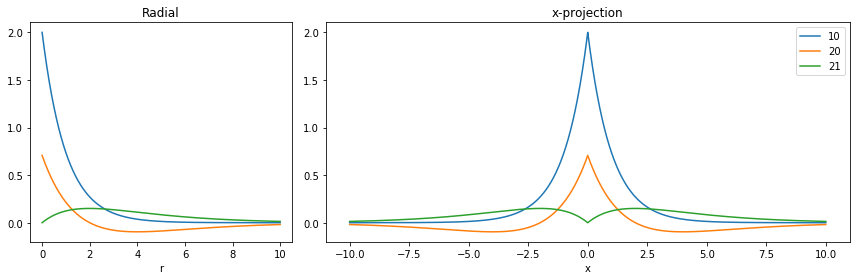

In [119]:
params = array([[1,0],[2,0],[2,1]]) # Can modify if you like, it is a list of [n,l]

r = linspace(0,10,1001)

def H_orb(n,l):
    return sqrt((2/n)**3 * (factorial(n-l-1)) / (2 * n * factorial(n+l)**3)) \
    * exp(-r/n) \
    * ((2*r)/n)**l \
    * assoc_laguerre((2*r/n), (n-l-1), (2*l + 1)) * factorial(n+l)

fig = plt.figure(figsize=(12, 4)) # Set up the plot
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title("Radial")
ax1.set_xlabel("r")

ax2.set_title("x-projection")
ax2.set_xlabel("x")

for p in params:
    R = H_orb(p[0], p[1])
    ax1.plot(r,R)    
    ax2.plot(append(-r[1:][::-1], r), append(R[1:][::-1], R), label = str(p[0])+str(p[1]))
    
ax2.legend()

plt.tight_layout()

But this form is very involved, and is only for hydrogen. An approximation to make calculations easier is known as the slater orbitals, and it argues that you can reasonably approximate a linear combination of the above orbitals (hydrogen-like) with linear combinations of the form 

$$ \Phi(r) = \big( \frac{Z^3}{\pi} \big)^{\frac12} e^{-Zr} $$

which is the same shape as the 1s orbital. However, this is hard to integrate, and so this form is then approximated to a linear combination of gaussians of the form 

$$ \Phi(r) = \big( \frac{2 \alpha}{\pi} \big)^{\frac34} e^{- \alpha r^2} $$

with coefficients that can be found online. This makes calculations easier, but less accurate.

See the difference on hydrogen 1s below for an approximation using 1, 2, and 3 gaussians.

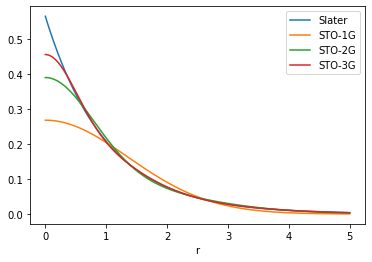

In [142]:
def STONG(r, coeffs):
    R = 0*r
    for ac in coeffs:
        R += ac[1] * (2*ac[0]/pi)**.75 * exp(-ac[0] * r * r)
    return R

r = linspace(0,5,1001)

Slater = (1/pi)**.5 * exp(-r)
Gauss1 = STONG(r, array([[0.270950, 1]]))
Gauss2 = STONG(r, array([[0.151623, 0.678914], [0.851819, 0.430129]]))
Gauss3 = STONG(r, array([[.109818, .444635],[.405771, .535328],[2.22766, .154329]]))

plt.plot(r, Slater, label="Slater")
plt.plot(r, Gauss1, label = "STO-1G")
plt.plot(r, Gauss2, label = "STO-2G")
plt.plot(r, Gauss3, label = "STO-3G")
plt.legend()
plt.xlabel("r");

So, we know the operations, and we know how orbitals are approximated, so lets get down to actaully solving simple 2 electron systems.

First we need to figure out the form of the fock operator mentioned above.

$$ f(i) = h(i) + v^\mathrm{HF}(i) =- \frac12 \nabla_i^2 - \sum_{A = 1}^M \frac{Z_A}{r_{iA}} + v^\mathrm{HF}(i)   $$

The last term is a term that represents the two-electron repulsion potential as an average 1-electron potential caused by all other electrons, and has a coulomb operator $\mathscr{J}$ and an exchange operator $\mathscr{K}$

$$ \mathscr{J}_b (1) \chi_a (1)= \langle \chi_b (2) | r_{12}^{-1} | \chi_b (2) \rangle \chi_a (1) = \big[ \int | \chi_b (2) |^2 r_{12}^{-1} d\mathbf{x}_2 \big] \chi_a (1) $$

$$ \mathscr{K}_b (1) \chi_a (1) = \langle \chi_b (2) | r_{12}^{-1} | \chi_a (2) \rangle \chi_b (1) = \big[ \int \chi_b^* (2) r_{12}^{-1} \chi_a (2) d\mathbf{x}_2 \big] \chi_b (1) $$

Where $\mathscr{J}_b (1)$ essentially gives the average potential on electron 1 from the averaged position and spin of an electron 2 in a specific spin orbital, and $ \mathscr{K}_b (1) $ has no intuitive understanding and lets just say it is a correction for how the wavefunction changes sign when you swap electrons.

These two operators combined get you the average potential of an electron from all other electrons in the system, and expand the fock operator as follows.

$$ f(1) = h(1) + v^\mathrm{HF}(1) = - \frac12 \nabla_1^2 - \sum_{A} \frac{Z_A}{r_{1a}} + \sum_{b \neq a} \mathscr{J}_b (1) - \sum_{b \neq a} \mathscr{K}_b (1)   $$

making our new eigenvalue problem

$$ \big[ h(1) + \sum_{b \neq a} \mathscr{J}_b (1) - \sum_{b \neq a} \mathscr{K}_b (1) \big] \chi_a (1) = \epsilon_a \chi_a (1)  $$

which can actually be cleaned up a bit to...

$$ f \chi_a = \epsilon_a \chi_a  $$

$$ f(1) = h(1) + \sum_{b} (\mathscr{J}_b (1) - \mathscr{K}_b (1)) = h(1) + v^\mathrm{HF}(1) $$


Derivations of these can be found in Szabo and Ostlund chapter 3.2, and the process is quite involved and I'd rather not recreate it. But this is the bare minimum knowledge we need to continue.


Now, I am gonna reference Szabo ad Ostlund 3.4.1's derivation for transfroming the spin orbital calculation into a calculation involving closed shell restricted spin orbitals, which means that the spin up and spin down spin orbitals for an orbital have the same spatial form, and that the system must have an even number of electrons. It is another approximation, but will be useful for us, as it means we will not have to account for spin inside of each orbital, meaning we only have to integrate over space, and it is functionally similar to the spin orbital derivation, just with some slight tweaks.

Our new fock operator becomes

$$ f(1) = h(1) + \sum_a^{N/2} 2 J_a(1) - K_a(1) $$

where the lack of a 2 in front of the exchange operator in the fock operator is caused by spin orthogonality making one of the 2 terms in an expansion 0 (Check the derivation if you don't belive me, it is a LOT to write in Markdown).

$$ J_a(1) = \int \Psi_a^*(2) r_{12}^{-1} \Psi_a(2) d\mathbf{r}_2 $$

$$ K_a(1) \Psi_i(1) = \big[ \int \Psi_a^*(2) r_{12}^{-1} \Psi_i(2) d\mathbf{r}_2 \big] \Psi_a(1) $$

and we get to keep the eigenvalue problem in the smae functional form of

$$ f(1) \Psi_a(1) = \epsilon_a \Psi_a(1)  $$

and to find the energy of the system, we simple take the wavefunction as a slater determinant of the spatial orbitals multiplied by generic spin functions $ | \mathbf{\Psi}_0 \rangle = | \psi_1 \bar{\psi}_1 ... \psi_a \bar{\psi}_a ... \psi_{N/2} \bar{\psi}_{N/2} \rangle $

$$ E_0 = \langle \mathbf{\Psi}_0 | \mathscr{H} | \mathbf{\Psi}_0 \rangle = 2 \sum_a h_{aa} + \sum_a \sum_b 2 J_{ab} - K_{ab}  $$

$$ h_{aa} = \int \psi_a^*(\mathbf{r}_1) h(\mathbf{r}_1) \psi_a(\mathbf{r}_1) d \mathbf{r}_1 $$

$$ J_{ab} = \int \psi_a^*(\mathbf{r}_1) \psi_a(\mathbf{r}_1) r_{12}^{-1} \psi_b^*(\mathbf{r}_1) \psi_b(\mathbf{r}_1) d \mathbf{r}_1 d \mathbf{r}_2 $$

$$ K_{ab} = \int \psi_a^*(\mathbf{r}_1) \psi_b(\mathbf{r}_1) r_{12}^{-1} \psi_b^*(\mathbf{r}_1) \psi_a(\mathbf{r}_1) d \mathbf{r}_1 d \mathbf{r}_2 $$

Now, the background is getting pretty long now, so I will skip the process of the Roothaan Equations, but I will tell you that they essentially define an iterative system of matrix problems that converge onto the correct atomic/molecular orbitals for the groundstate, and they can be compactly written as 

$$ \mathbf{FC} = \mathbf{SC \epsilon} $$

where $\mathbf{F}$ is the fock matrix, used for getting the energies of the orbitals, which are represented by the columns of $\mathbf{C}$. $\mathbf{S}$ is an overlap matrix, and $\mathbf{\epsilon}$ is a diganol matrix with all of the calculated orbital energies. You can calculate the correct $\mathbf{C}$ matrix by iteratively solving parts of this equation, and repeating until it stops changing. Szabo and Ostlund page 146 gives a clear step by step procedure.

I will know define some functions that we will need for the calculations. Ideally I would define them later for the purpose of this being a tutorial, but loading in functions unnecessarilly is bad coding practice. These will mainly be integrals that are defined and described in Appendix A of Szabo and Ostlund (what a great book) I also have made the executive decision of diagnolizing matrices using numpy functions. The matrices need here can actually be diagnolized through a specific pattern as they will be 2x2, but I want to generalize as much as possible and there are always great libraries around for diagnolization and genralized functions (like the error function), so use them if you can.

In [143]:
# generates a diaganol matrix from an array
def gen_diag(v):
    D = zeros((len(v), len(v)))
    for i in range(len(v)):
        D[i][i] += v[i]
    return D

# this calculates the F0 function, but for only s-type orbitals (l = 0) hence F0
def F0(t):
    return 0.5 * sqrt(pi/t) * erf(sqrt(t))

# I will be representing gaussians with A0[0] being the orbital coefficiant and A0[1] being it's normalization constant

# Solves for uv element in the overlap matrix
def Sab(Aa, Ab, Rab2):
    '''
    Solves for ab element in the overlap matrix
    A# is the orbital exponent and weight of the gaussian centered on atom # 
    Rab2 is the square of the distance between the two atoms
    '''
    a = Aa[0]
    b = Ab[0]
    return (pi/(a+b))**(1.5) * exp(-a*b*Rab2/(a+b)) * Aa[1] * Ab[1]

# Solves for uv element in the kinetic energy matrix
def Tab(Aa, Ab, Rab2):
    '''
    Solves for ab element in the kinetic energy matrix
    A# is the orbital exponent and weight of the gaussian centered on atom # 
    Rav2 is the square of the distance between the two atoms
    '''
    a = Aa[0]
    b = Ab[0]
    return (a*b/(a+b)) * (3-2*a*b*Rab2/(a+b)) * (pi/(a+b))**1.5 * exp(-a*b*Rab2/(a+b)) * Aa[1] * Ab[1]

# Solves for uv element in the Electron-Nuclear attraction potential matrix
def Vab(Aa, Ab, Rab2, Rpc2, Zc):
    '''
    Solves for ab element in the Electron-Nuclear attraction potential matrix
    A# is the orbital exponent and weight of the gaussian centered on atom # 
    Rab2 is the square of the distance between the two atoms
    Rpc2 is the square of the distance between the "center" of the gaussians when multipled and the nucleus of interest
    Zc is the charge of the nucleus
    '''
    a = Aa[0]
    b = Ab[0]
    return (-2*pi/(a+b)) * Zc * exp(-a*b*Rab2/(a+b)) * F0((a+b)*Rpc2) * Aa[1] * Ab[1]


# Solves for abcd element in the 2 electron integral tensor
def twoe(Aa, Ab, Ac, Ad, Rab2, Rcd2, Rpq2):
    '''
    Solves for ab element in the Electron-Nuclear attraction potential matrix
    A# is the orbital exponent and weight of the gaussian centered on atom # 
    Rab2/Rcd2 is the square of the distance between the two atoms
    Rpq2 is the square of the distance between the "centers" of the gaussians when multiplied
    Zc is the charge of the nucleus
    '''
    a = Aa[0]
    b = Ab[0]
    return (-2*pi/(a+b)) * Zc * exp(-a*b*Rab2/(a+b)) * F0((a+b)*Rpc2) * Aa[1] * Ab[1]


array([[1., 0., 0.],
       [0., 2., 0.],
       [0., 0., 3.]])